
# Import packages and directories necessary for this book

In [80]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from mixed_naive_bayes import MixedNB
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/drive/MyDrive/ColabNotebooks/modules')
import drive.MyDrive.ColabNotebooks.modules.helperFunctions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocess the Data into a workable DataFrame

## Import the hepler functions and process the data

In [81]:
# Import the support function "readFile". This function takes as an argument a .cvs file or the route to the file, imports and transforms it into a Pandas DataFrame, returning the loaded DataFrame
from drive.MyDrive.ColabNotebooks.modules.helperFunctions import readFile

# Import the support function "cleanMissingValues". This function takes the DataFrame as an argument and returns the same DataFrame with a treatment for the missing values. 
from drive.MyDrive.ColabNotebooks.modules.helperFunctions import cleanMissingValues

# Import the support function "cleanDataFrame". This function takes in the previous DataFrame and returns another DataFrame whit just the features and target, rearanged in a new better comprehensive column order.
from drive.MyDrive.ColabNotebooks.modules.helperFunctions import cleanDataFrame

# Import the support function "convertCategories". This function takes in the previous DataFrame and returns another with new categorization for some of the features. 
from drive.MyDrive.ColabNotebooks.modules.helperFunctions import convertCategories

# Import "useLabelEncoder". This function takes in the DataFrame and applies sklearn labelEncoder to finis formating the DataFrame
from drive.MyDrive.ColabNotebooks.modules.helperFunctions import useLabelEncoder

In [82]:
# Read the .csv file and assigns the name "df" to it.
# After that, we apply the support functions to the DataFrame in order to ger a new df ready to work with in the next ML algorithms

file = 'drive/MyDrive/ColabNotebooks/data/VPD_lowerMainLand.csv'
df = readFile(file)
df = cleanMissingValues(df)
df = cleanDataFrame(df)
df = convertCategories(df)
df.head(5)

,Month,Weather,Light,Alcohol Involved,Drug Involved,Fell Asleep,Cyclist Involved,Pedestrian Involved,Motorcycle Involved,Land Use,Speed Advisory,Traffic Control,Traffic Flow,Road Class,Road Character,Road Condition,Road Surface,Crash Type
0,10,0,0,0,0,0,0,0,0,0,0,7,1,0,0,1,1,1
1,2,0,0,0,0,0,0,0,0,1,0,5,1,1,0,0,0,0
2,6,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,9,0,0,0,0,0,0,0,0,5,0,0,1,1,0,0,0,1
4,8,0,1,0,0,0,0,0,0,0,0,0,1,1,1,6,0,1


In [83]:
# We check for the shape of our preprocessed data
df.shape

(91868, 18)

## Start defining the "X" and "y" for the MixMax escaled dfX dfy and the same for the dummy variables model.

### For the regular variables

In [84]:
# Here we select the features columns for the dfX and the target column for the dfy

# dfX is equal to all the features minus the target variable.
dfX = df.drop(['Crash Type'],axis=1)

# dfy is equal to just the target variable "Crash Type"
dfy = df['Crash Type']

### For the dummy variables

In [85]:
# Here we select the features columns for the dfdummyX and the target column for the dfdummyy.

# This time, we use the method "get_dummies" from Pandas so we can transform all the non-binary categories into a dummy representation of each feature.
dfdummyX = df.drop(['Crash Type'],axis=1)
dfdummyX = pd.get_dummies(data=dfdummyX, columns=['Month',
                                            'Weather',
                                            'Light',
                                            'Land Use',
                                            'Speed Advisory',
                                            'Traffic Control',
                                            'Traffic Flow',
                                            'Road Class',
                                            'Road Character',
                                            'Road Condition',
                                            'Road Surface',
                                            ])
dfdummyy = df['Crash Type']

## Create the train and test sets for the scled and dummy variables

### For the regular variables

In [86]:
# Now it's time to instantiate "train_test_split" class and transform dfX and dfy into the train and test sets.
# We are using a ratio of 70% for training and 30% for testing.
# Split the dfX in two equal parts
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.2, random_state=0)

### For the dummy variables

In [87]:
# The same goes for the dummy X and y sets. Instantiate "train_test_split" class and transform dfdummyX and dfdummyy into the train and test sets.
# We are using a ratio of 70% for training and 30% for testing.
# Split the dfdummyX into train and test datasets.
dummyX_train, dummyX_test, dummyy_train, dummyy_test = train_test_split(dfdummyX, dfdummyy, test_size=0.2, random_state=0)

## Scale the categorical data using MinMax escaler, so we can end up with a range of [0-1] for all the categorical data

In [88]:
# Here we instantiate a scaler using MinMaxScaler
scaler = MinMaxScaler()

# Fit on training and test sets
scaler.fit(X_train)
scaler.fit(X_test)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Start the models

## Random Forest Classifier: scaled variables (no tunning) - 63.46%

### Fit the scaled train set

In [41]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
display(rfc.score(X_train, y_train))

0.819971698369935

### Predict for scaled test set

In [43]:
y_pred = rfc.predict(X_test)

### Create confusion matrix and test score

In [47]:

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display(rfc.score(X_test, y_test))

,predicted 0,predicted 1
actual 0,7312,2673
actual 1,4040,4349


0.6346467834984216

## Random Forest Classifier: scaled variables (tunned) - 66.12%

In [48]:
# RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(X_train, y_train)
rs.best_params_

# Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
# [Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 223.0min finished
# {'bootstrap': False,
#  'max_depth': 13,
#  'max_features': 'log2',
#  'min_samples_leaf': 7,
#  'min_samples_split': 12,
#  'n_estimators': 300}

# Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
# [Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 219.8min finished
# {'bootstrap': False,
#  'max_depth': 13,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 12,
#  'min_samples_split': 18,
#  'n_estimators': 400}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 33.6min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 23,
 'n_estimators': 700}

In [49]:
# #save the model to disk
filename = 'drive/MyDrive/ColabNotebooks/models/stClassifier/scaled_rfs_rs.pkl'
pickle.dump(rs, open(filename, 'wb'))

In [51]:
# load the model from disk
scaled_rfc_gs = pickle.load(open(filename, 'rb'))
result = scaled_rfc_gs.score(X_test, y_test)
print(result)

0.6610972025688473


In [52]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time',
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(3)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,23,7,log2,15,False,0.667361,1
1,600,23,2,sqrt,15,False,0.667075,2
2,100,2,18,sqrt,15,False,0.666884,3


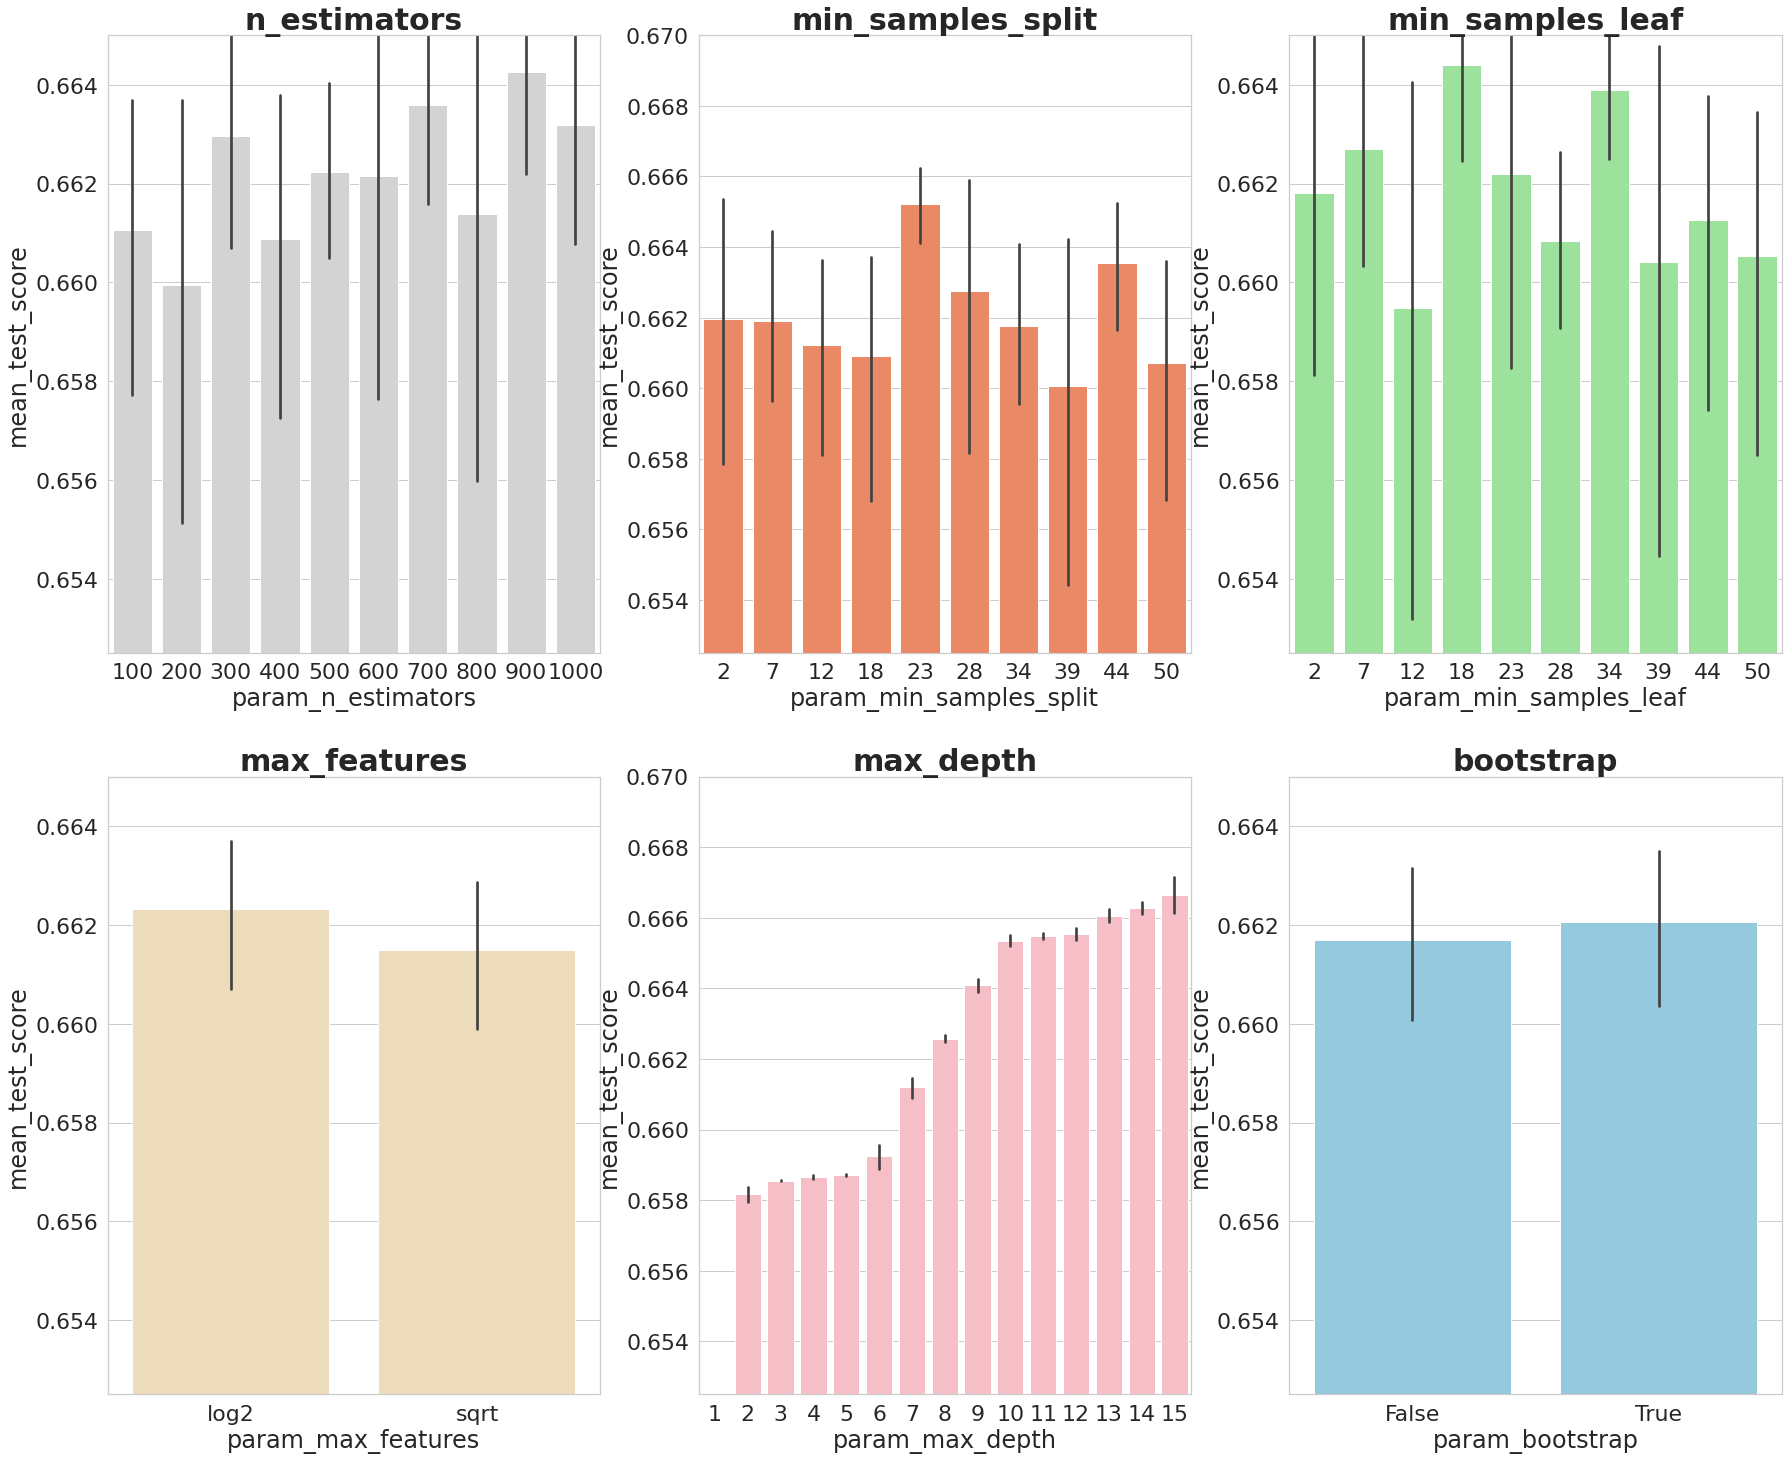

In [57]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.6525,.665]), axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.6525,.67]), axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.6525,.665]), axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.6525,.665]), axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.6525,.67]), axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.6525,.665])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

In [66]:
# GridSearchCV
n_estimators = [700,900]
max_features = ['log2']
max_depth = [15,12,25]
min_samples_split = [23,44]
min_samples_leaf = [18,34]
bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

scaled_gs = GridSearchCV(rfc,
                         param_grid,
                         cv = 3,
                         verbose = 3,
                         n_jobs=-1)

scaled_gs.fit(X_train, y_train)
rfc_GS = scaled_gs.best_estimator_
scaled_gs.best_params_

# Fitting 3 folds for each of 6 candidates, totalling 18 fits
# [Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished
# {'bootstrap': False,
#  'max_depth': 12,
#  'max_features': 'log2',
#  'min_samples_leaf': 28,
#  'min_samples_split': 2,
#  'n_estimators': 800}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 13.0min finished


{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 18,
 'min_samples_split': 44,
 'n_estimators': 900}

In [67]:
# save the model to disk
filename = 'drive/MyDrive/ColabNotebooks/models/randomForestClassifier/scaled_rfc_gs.pkl'
pickle.dump(scaled_gs, open(filename, 'wb'))

In [69]:
# load the model from disk
scaled_rfc_gs = pickle.load(open(filename, 'rb'))
result = scaled_rfc_gs.score(X_test, y_test)
print(result)

0.6612060520300425


In [73]:
y_pred_gs = scaled_gs.best_estimator_.predict(X_test)

In [74]:

conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_tuned_pca)
display(scaled_rfc_gs.score(X_test, y_test))

,predicted 0,predicted 1
actual 0,8894,1091
actual 1,5134,3255


0.6612060520300425

## Random Forest Classifier: scaled variables (tunned, PCA) - 60.38%

### Here "X_train set for PCA transformation. 

*   Using 5 components, we can explain 0.91% of the variability in the original data.

### Apply PCA to scaled train set

In [105]:
# Loop Function to identify number of principal components that explain at least 90% of the variance
for comp in range(3, dfX.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(dfX)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.90:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
Final_PCA.fit(dfX)
dfX_PCA = Final_PCA.transform(dfX)
num_comps = comp_check.shape[0]
print("dfX_PCA: Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

dfX_PCA: Using 5 components, we can explain 0.9152177015727666% of the variability in the original data.


In [106]:
# 5 components can explain 90%+ of the variability in the original data.
# Now we need to plot the scree plot to observe much more clearily the PCA behavior.

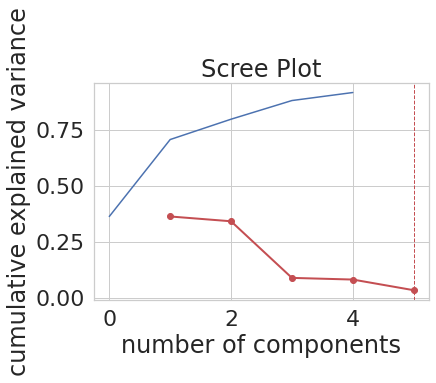

In [108]:
# We may use 5 principal components as the plots scree rule can be verified thanks to that plot.

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')

plt.axvline(linewidth=1, color='r', linestyle = '--', x=5, ymin=0, ymax=1)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [109]:
# As previously mentioned, we can choose 8 principal components out of the original 32 and still explain 70%+ of the variance of the original sample.
# Here, the original dataframe dfdummyX its used to extract the 8 principal components out of the already transformed dummy variables

n_components = 5

pca = PCA(n_components = n_components)

Principal_components=pca.fit_transform(dfX)
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_df.head(3)

,PC1,PC2,PC3,PC4,PC5
0,-4.485378,3.225957,-3.920573,0.631040,-0.396201
1,3.576491,1.950540,-2.118044,0.735327,-0.493900
2,-0.250343,-3.240057,-1.939899,-0.535422,-0.396254


In [110]:
# Split the dfcatX in two equal parts
pcaX_train, pcaX_test, pcay_train, pcay_test = train_test_split(pca_df, dfy, test_size=0.3, random_state=123)

In [ ]:
# After performing PCA, we can also try some hyperparameter tuning to tweak our Random Forest to try and get better predicting performance.
# First, we can start with RandomSearchCV to consider a wide range of values.

In [114]:
# RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(pcaX_train, pcay_train)
rs.best_params_

# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# [Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 70.9min finished

# {'bootstrap': True,
#  'max_depth': 10,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 7,
#  'min_samples_split': 12,
#  'n_estimators': 1000}

# Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
# [Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 837.1min finished
# {'bootstrap': True,
#  'max_depth': 13,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 23,
#  'min_samples_split': 7,
#  'n_estimators': 800}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 66.5min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 600}

In [115]:
# save the model to disk
filename = 'drive/MyDrive/ColabNotebooks/models/randomForestClassifier/pca_rfc_rs.pkl'
pickle.dump(rs, open(filename, 'wb'))

In [118]:
# load the model from disk
pca_rfc_gs = pickle.load(open(filename, 'rb'))
result = pca_rfc_gs.score(pcaX_test, pcay_test)
print(result)

0.6038968107107869


In [119]:
# To get a good range of values to try next, we can easily get a dataframe of our RandomSearchCV results.

rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time',
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(3)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,600,23,2,sqrt,15,False,0.608658,1
1,700,23,7,log2,15,False,0.607881,2
2,800,28,12,sqrt,14,True,0.607663,3


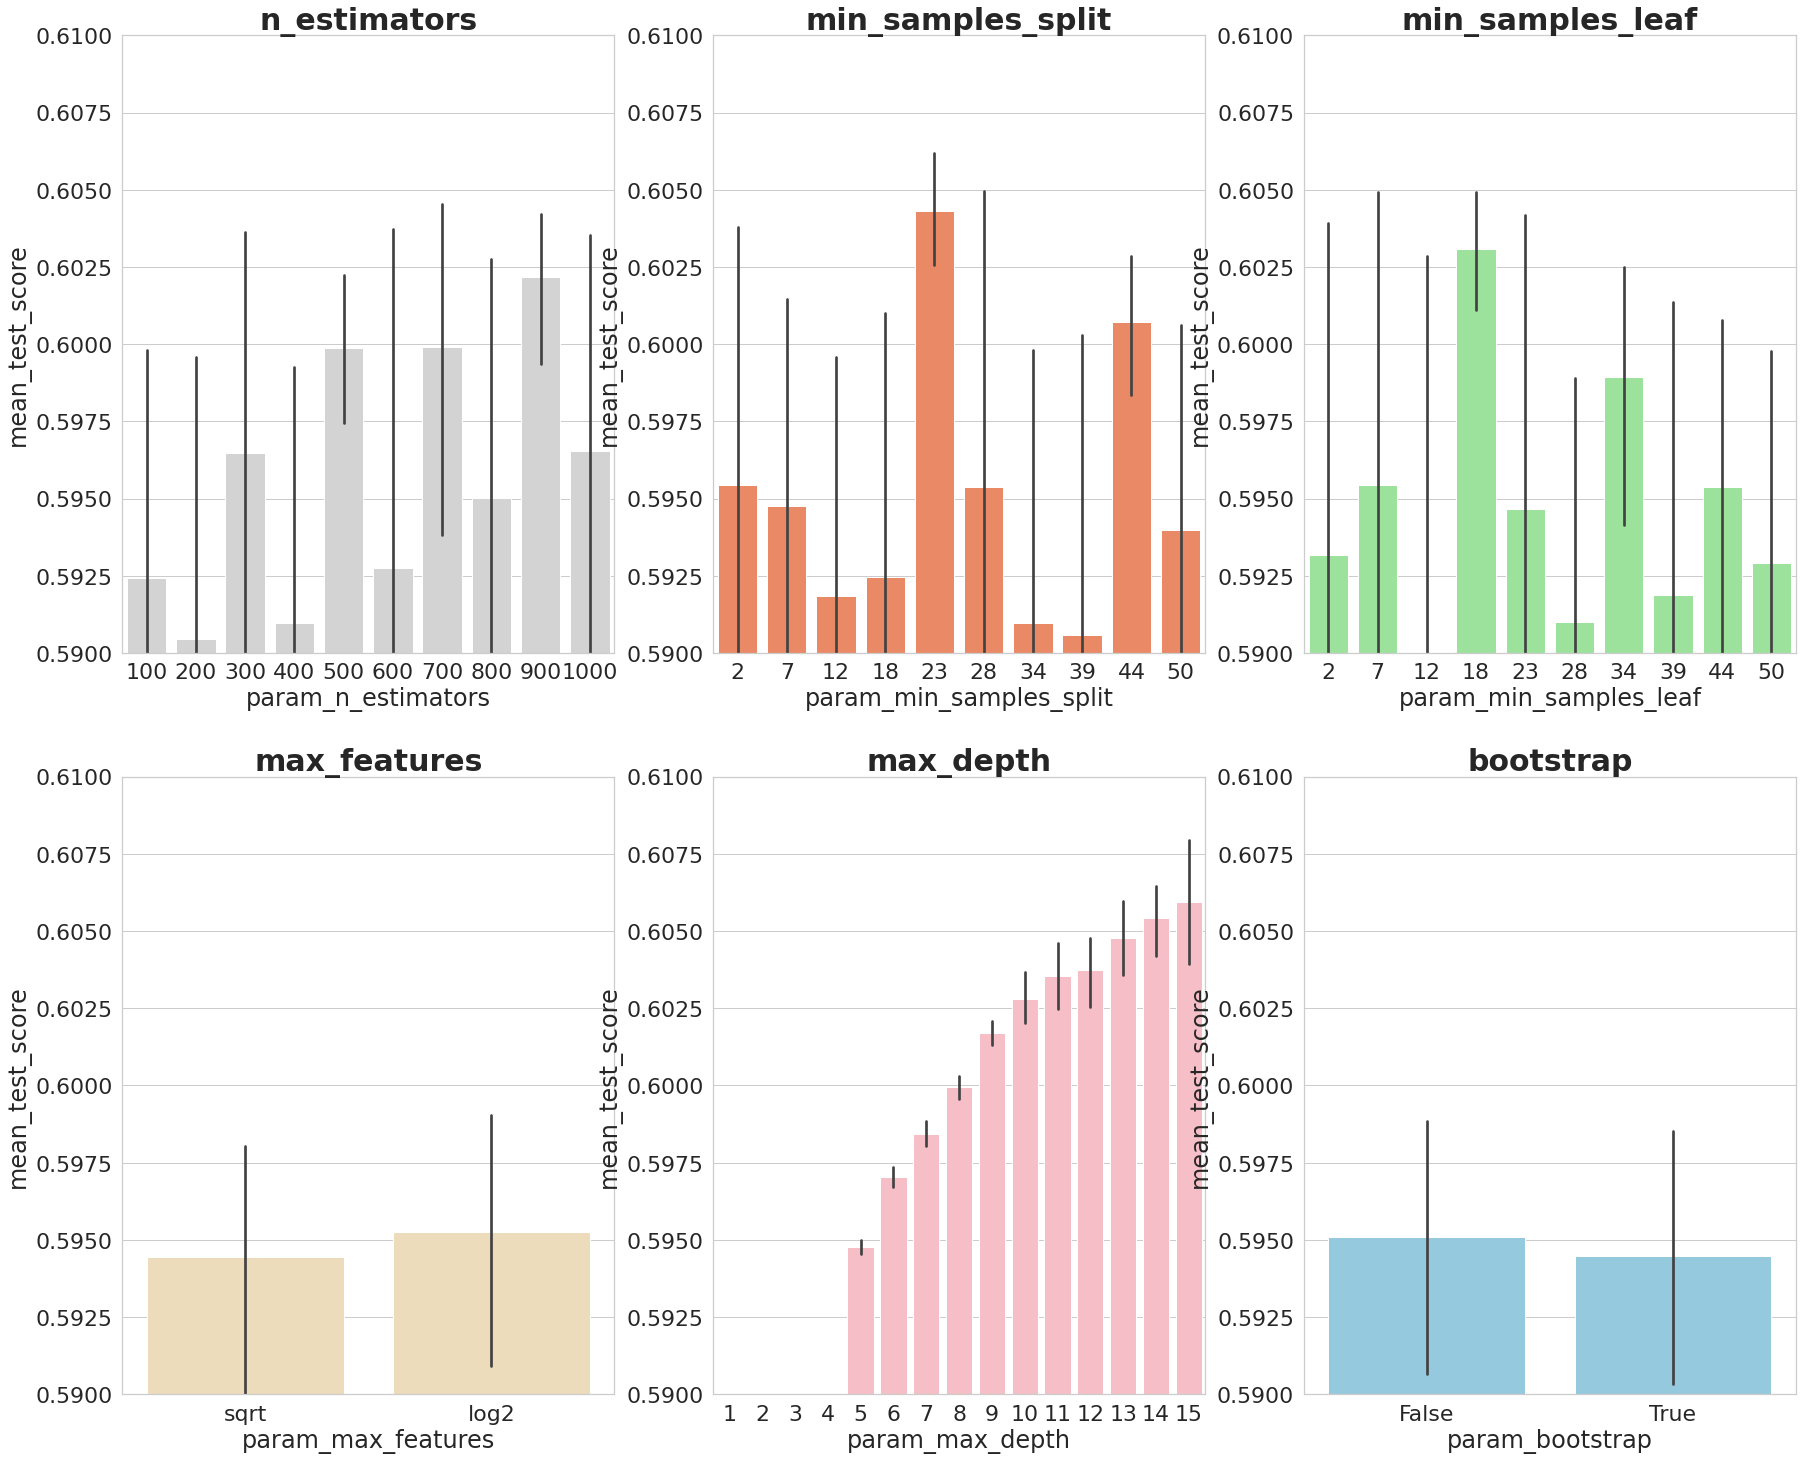

In [123]:
# Now, let’s create bar plots of each hyperparameter on the x-axis, and the mean score of the models made at each value, to see which values were most successful on average:

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.59,.61]), axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.59,.61]), axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.59,.61]), axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.59,.61]), axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.59,.61]), axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.59,.61])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

In [ ]:
# Looking at the plots above, we can extract insights about how well each value for each hyperparameter performed on average.
# n_estimators: 500, 700 seem to have the highest average scores.
# min_samples_split: smaller values like 23 and 44 seem to have higher scores. There are also high scores at 23. We can try a few values above 2, and a few values around 23.
# min_samples_leaf: smaller values seem to correlate with higher scores…we can try values between 18–34.
# max_features: “log2” has the highest average score.
# max_depth: 15, 25 seem to do well.
# bootstrap: “False” has the highest average score.

In [ ]:
# After using RandomSearchCV, we can use GridSearchCV to perform a more refined search for our best hyperparameters.
# GridSearchCV
n_estimators = [500,700]
max_features = ['log2']
max_depth = [15,25]
min_samples_split = [23,44]
min_samples_leaf = [18,34]
bootstrap = [False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

scaled_gs = GridSearchCV(rfc,
                         param_grid,
                         cv = 3,
                         verbose = 3,
                         n_jobs=-1)

scaled_gs.fit(pcaX_train, pcay_train)
rfc_GS = scaled_gs.best_estimator_
scaled_gs.best_params_

# Fitting 3 folds for each of 6 candidates, totalling 18 fits
# [Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished
# {'bootstrap': False,
#  'max_depth': 12,
#  'max_features': 'log2',
#  'min_samples_leaf': 28,
#  'min_samples_split': 2,
#  'n_estimators': 800}

# Fitting 3 folds for each of 16 candidates, totalling 48 fits
# [Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 23.6min finished
# {'bootstrap': False,
#  'max_depth': 15,
#  'max_features': 'log2',
#  'min_samples_leaf': 18,
#  'min_samples_split': 44,
#  'n_estimators': 700}

In [125]:
# save the model to disk
filename = 'drive/MyDrive/ColabNotebooks/models/randomForestClassifier/scaled_rfc_gs.pkl'
pickle.dump(scaled_gs, open(filename, 'wb'))

In [127]:
# load the model from disk
rfc_gs = pickle.load(open(filename, 'rb'))
result = rfc_gs.score(pcaX_test, pcay_test)
print(result)

0.6038605275570552


In [129]:
pcay_pred_gs = rfc_gs.best_estimator_.predict(pcaX_test)

In [133]:

conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(pcay_test, pcay_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_tuned_pca)
display(scaled_gs.score(pcaX_test, pcay_test))

,predicted 0,predicted 1
actual 0,10474,4531
actual 1,6387,6169


0.6038605275570552

## Random Forest Classifier: dummy variables - 62.27%

In [134]:
# First, we can start with RandomSearchCV to consider a wide range of values.

In [135]:
# RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(dummyX_train, dummyy_train)
rs.best_params_

# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
# [Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.4min
# [Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.5min finished
# {'bootstrap': True,
#  'max_depth': 14,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 12,
#  'min_samples_split': 28,
#  'n_estimators': 800}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.5min finished


{'bootstrap': True,
 'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples_split': 28,
 'n_estimators': 800}

In [136]:
# #save the model to disk
filename = 'drive/MyDrive/ColabNotebooks/models/randomForestClassifier/dummy_rfs_rs.pkl'
pickle.dump(rs, open(filename, 'wb'))

In [137]:
# load the model from disk
dummy_rfc_gs = pickle.load(open(filename, 'rb'))
result = dummy_rfc_gs.score(dummyX_test, dummyy_test)
print(result)

0.6616958746054207


In [138]:
# To get a good range of values to try next, we can easily get a dataframe of our RandomSearchCV results.

rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time',
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(3)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,800,28,12,sqrt,14,True,0.665687,1
1,400,23,12,sqrt,11,True,0.665415,2
2,1000,44,2,sqrt,9,True,0.665388,3


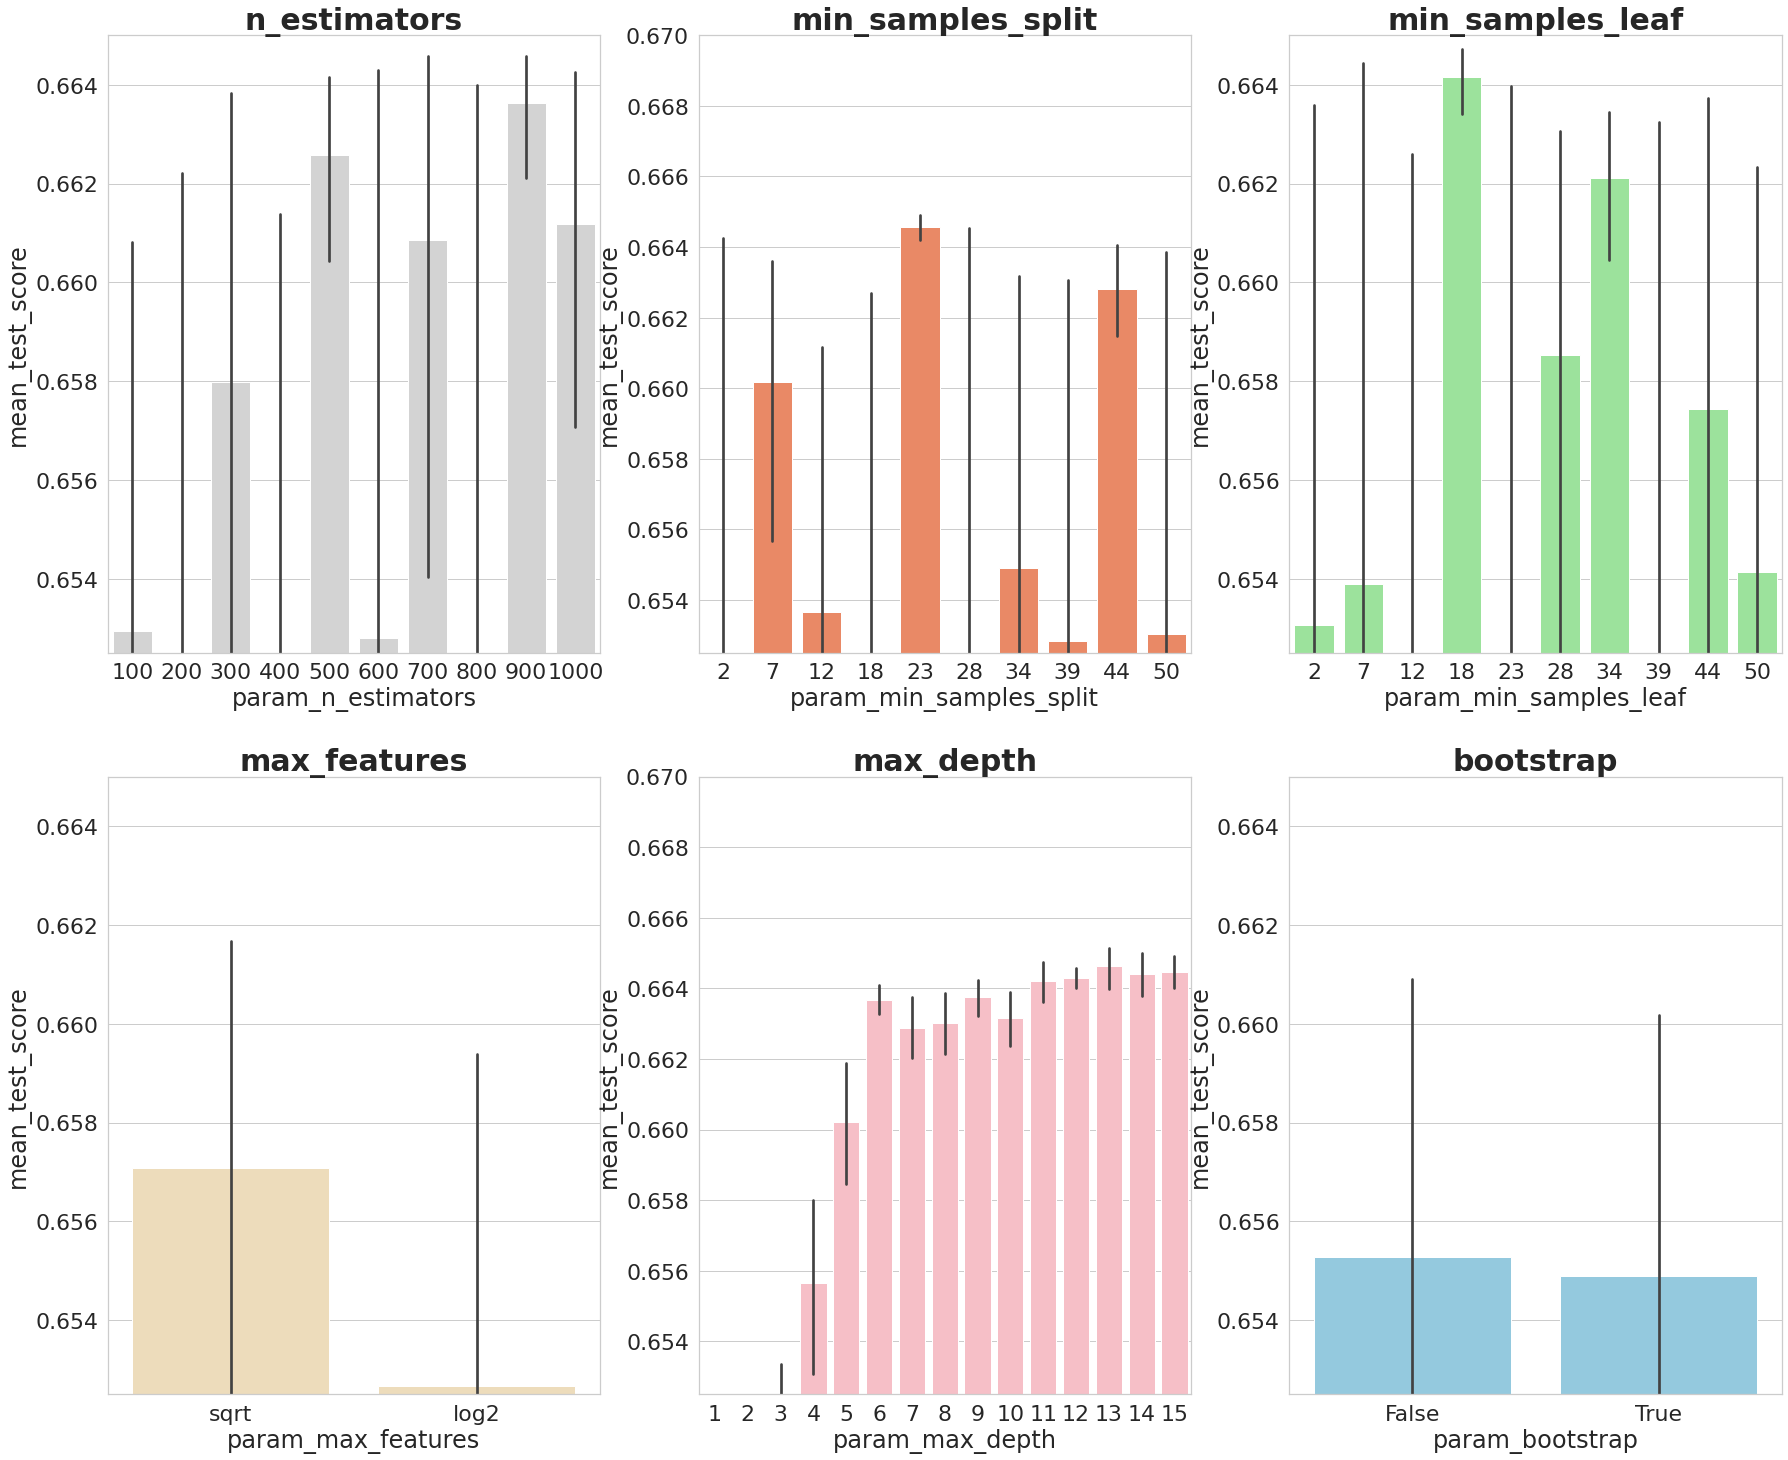

In [140]:
# Now, let’s create bar plots of each hyperparameter on the x-axis, and the mean score of the models made at each value, to see which values were most successful on average:

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.6525,.665]), axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.6525,.67]), axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.6525,.665]), axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.6525,.665]), axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.6525,.67]), axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.6525,.665])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

In [ ]:
# Looking at the plots above, we can extract insights about how well each value for each hyperparameter performed on average.
# n_estimators: 500, 700 seem to have the highest average scores.
# min_samples_split: smaller values like 23 and 44 seem to have higher scores. There are also high scores at 23. We can try a few values above 2, and a few values around 23.
# min_samples_leaf: smaller values seem to correlate with higher scores…we can try values between 18–34.
# max_features: “log2” has the highest average score.
# max_depth: 15, 25 seem to do well.
# bootstrap: “False” has the highest average score.

In [141]:
# GridSearchCV
n_estimators = [500,900]
max_features = ['sqrt']
max_depth = [13,15]
min_samples_split = [7,23,44]
min_samples_leaf = [18,34]
bootstrap = [False]

dummy_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

dummy_grid = GridSearchCV(rfc,
                         param_grid,
                         cv = 3,
                         verbose = 3,
                         n_jobs=-1)

dummy_grid.fit(dummyX_train, dummyy_train)
rfc_GS = dummy_grid.best_estimator_
dummy_grid.best_params_

# Fitting 3 folds for each of 6 candidates, totalling 18 fits
# [Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished
# {'bootstrap': False,
#  'max_depth': 12,
#  'max_features': 'log2',
#  'min_samples_leaf': 28,
#  'min_samples_split': 2,
#  'n_estimators': 800}

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 10.1min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 18,
 'min_samples_split': 23,
 'n_estimators': 700}

In [142]:
# save the model to disk
filename = 'drive/MyDrive/ColabNotebooks/models/randomForestClassifier/dummy_rfc_gs.pkl'
pickle.dump(dummy_grid, open(filename, 'wb'))

In [144]:
# load the model from disk
dummy_grid = pickle.load(open(filename, 'rb'))
result = dummy_grid.score(dummyX_test, dummyy_test)
print(result)

0.6627299444867748


In [147]:
dummyy_pred_gs = dummy_grid.best_estimator_.predict(dummyX_test)

In [149]:

conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(dummyy_test, dummyy_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_tuned_pca)
display(dummy_grid.score(dummyX_test, dummyy_test))

,predicted 0,predicted 1
actual 0,8241,1744
actual 1,4453,3936


0.6627299444867748

## Random Forest Classifier: dummy variables (PCA) - 60.12%

### Here "dummyX_train" is used for PCA transformation. 

*   Using 32 components, we can explain 0.90% of the variability in the original data.

### Apply PCA to dummy train set

In [31]:
# Loop Function to identify number of principal components that explain at least 90% of the variance.
# This is important for the better understanding of the PCA explained variance that we need to decide on the  future number of principal components

for comp in range(3, dfdummyX.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(dfdummyX)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.90:
        break
        
dummyX_PCA = PCA(n_components= final_comp,random_state=42)
dummyX_PCA.fit(dummyX_train)
dummyX_PCA = dummyX_PCA.transform(dfdummyX)
num_comps = comp_check.shape[0]
print("dummyX_PCA: Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

dummyX_PCA: Using 32 components, we can explain 0.903736968527876% of the variability in the original data.


In [ ]:
# 32 components can explain 90%+ of the variability in the original data.
# Now we need to plot the scree plot to observe much more clearily the PCA behavior.

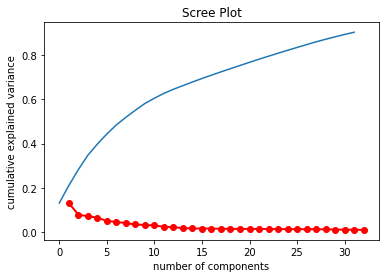

In [32]:
# We may use 8 or 10 principal components as the plots scree rule can be verified thanks to that plot.

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
# plt.show()

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [33]:
# Here we can get an idea of the cumulative proportion of variance explained and the correlation with each principal component created.

print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
    
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print("Cumulative Prop. Variance Explained: ", out_sum)
print('Principal components explained variance:', pca.explained_variance_) 

Proportion of Variance Explained :  [0.13158689 0.07888133 0.07186836 0.06510777 0.05045871 0.04586254
 0.0408902  0.03449803 0.03202591 0.03038351 0.02393459 0.02200986
 0.01844745 0.01638542 0.01631873 0.01591709 0.01510895 0.01496538
 0.01447098 0.01437158 0.01425496 0.01409737 0.01362523 0.01338247
 0.01317123 0.01297986 0.01282468 0.01256321 0.01157935 0.01096627
 0.01087785 0.00992121]
Cumulative Prop. Variance Explained:  [0.13158689 0.21046822 0.28233658 0.34744435 0.39790307 0.4437656
 0.4846558  0.51915383 0.55117974 0.58156325 0.60549784 0.6275077
 0.64595514 0.66234057 0.6786593  0.69457639 0.70968534 0.72465072
 0.73912169 0.75349327 0.76774824 0.78184561 0.79547084 0.80885331
 0.82202453 0.83500439 0.84782907 0.86039228 0.87197163 0.8829379
 0.89381576 0.90373697]
Principal components explained variance: [0.72996609 0.4375869  0.39868309 0.36117933 0.27991503 0.25441817
 0.22683462 0.19137463 0.17766075 0.16854969 0.13277495 0.12209764
 0.10233551 0.09089662 0.09052667 0.

In [34]:
# As previously mentioned, we can choose 8 principal components out of the original 32 and still explain 70%+ of the variance of the original sample.
# Here, the original dataframe dfdummyX its used to extract the 8 principal components out of the already transformed dummy variables

n_components = 8

pca = PCA(n_components = n_components)

Principal_components=pca.fit_transform(dfdummyX)
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
pca_df.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.221483,0.030757,-0.372801,-0.523799,-0.432494,0.835221,-0.478212,-0.470090
1,-0.841072,0.310287,-0.083247,-0.153540,0.937760,-0.341193,-0.260503,-0.087842
2,-0.176472,-1.019915,0.204063,0.969084,-0.686966,0.263421,-0.044134,0.407755


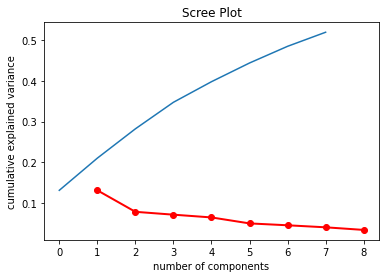

In [35]:

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], index=dfdummyX.columns)
loadings

In [37]:
# Split the dfcatX in two equal parts
pcaX_train, pcaX_test, pcay_train, pcay_test = train_test_split(pca_df, dfy, test_size=0.3, random_state=123)

### Fit Random Forest Classifier to the PCA dummy train set

In [38]:
rfc = RandomForestClassifier()
rfc.fit(pcaX_train, pcay_train)
display(rfc.score(pcaX_train, pcay_train))

0.8259131976301181

### Predict for PCA dummy test set

In [39]:
pcay_pred = rfc.predict(pcaX_test)

### Create the confusion matrix and test score

In [40]:
conf_matrix_baseline = pd.DataFrame(confusion_matrix(pcay_test, pcay_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display(rfc.score(pcaX_test, pcay_test))

,predicted 0,predicted 1
actual 0,10561,4444
actual 1,6267,6289


0.6113711403795218

In [ ]:
# After using RandomSearchCV, we can use GridSearchCV to perform a more refined search for our best hyperparameters.
# GridSearchCV
n_estimators = [500,700,900]
max_features = ['log2']
max_depth = [10,11,12]
min_samples_split = [23,44]
min_samples_leaf = [18, 34]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 3, n_jobs=-1)
gs.fit(pcaX_train, pcay_train)
rfc_GS = gs.best_estimator_
gs.best_params_

# Fitting 3 folds for each of 36 candidates, totalling 108 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.8min
# [Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 37.1min finished
# {'bootstrap': True,
#  'max_depth': 10,
#  'max_features': 'log2',
#  'min_samples_leaf': 18,
#  'min_samples_split': 44,
#  'n_estimators': 700}

# Fitting 3 folds for each of 36 candidates, totalling 108 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.0min
# [Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 37.9min finished
# {'bootstrap': True,
#  'max_depth': 12,
#  'max_features': 'log2',
#  'min_samples_leaf': 18,
#  'min_samples_split': 44,
#  'n_estimators': 500}

In [33]:
# save the model to disk
filename = 'drive/MyDrive/ColabNotebooks/models/randomForestClassifier/pca_rfc_gs.pkl'
pickle.dump(gs, open(filename, 'wb'))

In [37]:
# load the model from disk
PCA_RFC_GS = pickle.load(open(filename, 'rb'))
result = PCA_RFC_GS.score(pcaX_test, pcay_test)
print(result)

0.5903627504060639


In [38]:
y_pred_gs = PCA_RFC_GS.best_estimator_.predict(X_train_PCA)

In [39]:

conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_tuned_pca)
display(gs.score(X_train_PCA, y_test))

,predicted 0,predicted 1
actual 0,8911,6299
actual 1,5050,7445


0.5903627504060639